In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=9f87267dfb35b3f091566392d54d533383acbf76fba206ddbf5b1f87508ff130
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import sys
import shutil
import random
import matplotlib.pyplot as plt
import zipfile
import wget
%matplotlib inline

In [4]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/computer-vision-implementations'
GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['dlib.ipynb', 'calculate_the_vehicle_speed_using_opencv.ipynb', 'car_plate_recognation_using_opencv.ipynb', 'text_and_number_detection_by_using_pytesseract_ocr.ipynb', 'Mouse_Event_line_example.ipynb', 'image_Histograms_and_contrast_stretching_using_opencv.ipynb', 'eye_motion_detection_and_tracking_using_opencv.ipynb', 'face_mesh_in_video_using_mediapipe.ipynb', 'text_recognation_from_image_by_using_pytesseract_ocr.ipynb', 'segmentation_by_using_otsu_binarization.ipynb', 'image_blending_using_pyramid.ipynb', 'draw_contours_in_opencv.ipynb', 'thresholding_with_matplotlib.ipynb', 'Show_Date_and_Time_on_Videos_using_OpenCV_Python.ipynb', 'harris_corner_detector_in_python.ipynb', 'change_image_color_with_trackbar_opencv.ipynb', 'make_object_detection_using_HSV_color_space.ipynb', 'SIFT_example_using_opencv.ipynb', 'calculate_the_vehicle_speed_using_opencv (1).ipynb', 'Read_Write_Show_Videos_from_Camera_in_OpenCV.ipynb', 'Handle_Mouse_Events_in_OpenCV.ipynb', 'blob_detection_usin_opencv.ip

In [5]:
data_set_path = GOOGLE_DRIVE_PATH +'/files/'

In [6]:
#wget -P data_set_path https://github.com/ardamavi/Sign-Language-Digits-Dataset/archive/refs/heads/master.zip

In [7]:
if not os.path.exists(data_set_path+'/Dataset'):
    url = 'https://github.com/ardamavi/Sign-Language-Digits-Dataset/archive/refs/heads/master.zip'
    filename = wget.download(url)
    with zipfile.ZipFile('Sign-Language-Digits-Dataset-master.zip') as zf:
        zf.extractall(data_set_path)
    os.remove('Sign-Language-Digits-Dataset-master.zip')
    shutil.move(data_set_path+f'Sign-Language-Digits-Dataset-master/Dataset',data_set_path)
    shutil.rmtree(data_set_path+f'/Sign-Language-Digits-Dataset-master')

In [8]:
print(os.listdir(data_set_path+'/Dataset'))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [9]:
if os.path.exists(data_set_path+'Dataset/train/0/') is False:
    if not os.path.exists(data_set_path+'Dataset/train'):
        os.mkdir(data_set_path+'Dataset/train')
    if not os.path.exists(data_set_path+'Dataset/test'):
      os.mkdir(data_set_path+'Dataset/test')
    if not os.path.exists(data_set_path+'Dataset/valid'):
      os.mkdir(data_set_path+'Dataset/valid')

    for i in range(0,10):
        shutil.move(data_set_path+f'Dataset/{i}',data_set_path+'Dataset/train')
        os.mkdir(data_set_path+f'Dataset/valid/{i}')
        os.mkdir(data_set_path+f'Dataset/test/{i}')
        valid_samples = random.sample(os.listdir(data_set_path+f'Dataset/train/{i}'),30)
        for j in valid_samples:
            shutil.move(data_set_path+f'Dataset/train/{i}/{j}',data_set_path+f'Dataset/valid/{i}')
        test_samples = random.sample(os.listdir(data_set_path+f'Dataset/train/{i}'),5)
        for k in test_samples:
            shutil.move(data_set_path+f'Dataset/train/{i}/{k}',data_set_path+f'Dataset/test/{i}')


In [10]:
print(os.listdir(data_set_path+'Dataset/valid'))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [11]:
train_path = data_set_path+'Dataset/train'
valid_path = data_set_path+'Dataset/valid'
test_path = data_set_path+'Dataset/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory = train_path,target_size=(224,224),batch_size=10
)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory = valid_path,target_size=(224,224),batch_size=10
)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory = test_path,target_size=(224,224),batch_size=10,shuffle=False
)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [12]:
mobile =tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                 

In [13]:
x = mobile.layers[-5].output

#model.add(Reshape((1, 1, -1)))
#x = tf.keras.layers.Flatten()(x)
#(None, 1, 1, 1024)
#tf.keras.layers.Reshape((-1,1024))(x)
#tf.reshape(x, [-1,1024])
#x=tf.reshape(x, (-1,1024))

x = tf.keras.layers.Flatten()(x)
x

<KerasTensor: shape=(None, 1024) dtype=float32 (created by layer 'flatten')>

In [14]:
x.shape

TensorShape([None, 1024])

In [15]:
output = Dense(units=10,activation='softmax')(x)


In [16]:
model = Model(inputs=mobile.input,outputs=output)

In [17]:
print(len(model.layers))

89


In [18]:
for layer in model.layers[:-24]:
    layer.trainable =False

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [20]:
model.compile(optimizer = Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=30,
          verbose=2)

Epoch 1/30
172/172 - 25s - loss: 0.6163 - accuracy: 0.8283 - val_loss: 0.3663 - val_accuracy: 0.8667 - 25s/epoch - 148ms/step
Epoch 2/30
172/172 - 7s - loss: 0.1147 - accuracy: 0.9807 - val_loss: 0.1279 - val_accuracy: 0.9733 - 7s/epoch - 43ms/step
Epoch 3/30
172/172 - 6s - loss: 0.0562 - accuracy: 0.9930 - val_loss: 0.0798 - val_accuracy: 0.9800 - 6s/epoch - 36ms/step
Epoch 4/30
172/172 - 6s - loss: 0.0357 - accuracy: 0.9971 - val_loss: 0.0606 - val_accuracy: 0.9867 - 6s/epoch - 37ms/step
Epoch 5/30
172/172 - 7s - loss: 0.0220 - accuracy: 0.9982 - val_loss: 0.0535 - val_accuracy: 0.9867 - 7s/epoch - 40ms/step
Epoch 6/30
172/172 - 6s - loss: 0.0175 - accuracy: 0.9994 - val_loss: 0.0503 - val_accuracy: 0.9900 - 6s/epoch - 37ms/step
Epoch 7/30
172/172 - 7s - loss: 0.0111 - accuracy: 0.9994 - val_loss: 0.0403 - val_accuracy: 0.9867 - 7s/epoch - 40ms/step
Epoch 8/30
172/172 - 6s - loss: 0.0101 - accuracy: 0.9994 - val_loss: 0.0335 - val_accuracy: 0.9933 - 6s/epoch - 35ms/step
Epoch 9/30
17

In [22]:
test_labels = test_batches.classes

In [23]:
predictions = model.predict(x=test_batches,steps=len(test_batches),verbose=0)

In [24]:
cm = confusion_matrix(y_true=test_labels,y_pred=predictions.argmax(axis=1))
cm

array([[5, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 5, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 5, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 5, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 5]])

In [28]:
def plot_confusion_matrix(cm,classes,normalize= False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axos=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix,without normalization')
    print(cm)
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thresh else 'black')
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')


In [29]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix,without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


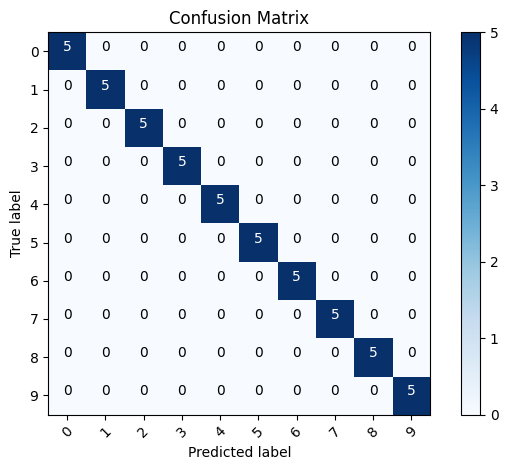

In [30]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')